In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import normalize
from scipy import interp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
sys.path.append('/home/lolo/Desktop/dnnComm/vde/vde/')
from vde import VDE 

name= '/home/lolo/Desktop/dnnComm/RML2016.10a_dict.pkl'
data = pd.read_pickle(name)

In [2]:
list = []
for d in data:
    list.append(d)    

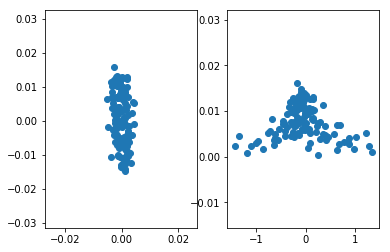

(1000, 2, 128) 220


In [3]:
# what is the best presentation for I/Q components?
# (x,y) or (angle,amplitude). we continue with (x,y)
dp0 = data[list[35]]
dp1 = data[list[205]]
dp2 = data[list[14]]
plt.figure()
plt.subplot(1,2,1);  plt.scatter(dp1[1, 0,:], dp1[1, 1,:]); 
plt.subplot(1,2,2); plt.scatter(np.arctan(dp1[1, 0,:]/dp1[1, 1,:]), np.sqrt(dp1[1, 0,:]**2+dp1[1, 1,:]**2));
plt.show()
print(data[list[0]].shape, len(list))

In [4]:
print (list)

[('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4', 4), ('G

In [5]:
# what is the best normalization strategy?
trajs = []
stride = 10
for l in range(len(list)):
    d = data[list[l]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l1')
        #dd = normalize(dd, axis=0, norm='l2')
        trajs.append(dd.T)
print (trajs[100].shape)    
print (len(trajs))

(128, 2)
22000


In [7]:
lag_time = 16
mdl = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=6,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=True, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [9]:
mdl.fit(trajs)

Epoch: 0
Batch 100, loss = 0.9572
rec_loss = 0.0250, autocorr_loss = 0.9322
Batch 200, loss = 0.8817
rec_loss = 0.0321, autocorr_loss = 0.8495
Batch 300, loss = 0.9805
rec_loss = 0.0305, autocorr_loss = 0.9501
Batch 400, loss = 1.0622
rec_loss = 0.0223, autocorr_loss = 1.0399
Batch 500, loss = 1.1112
rec_loss = 0.0203, autocorr_loss = 1.0908
Batch 600, loss = 1.1374
rec_loss = 0.0196, autocorr_loss = 1.1178
Batch 700, loss = 0.9465
rec_loss = 0.0187, autocorr_loss = 0.9279
Batch 800, loss = 0.9442
rec_loss = 0.0142, autocorr_loss = 0.9300
Batch 900, loss = 0.7988
rec_loss = 0.0156, autocorr_loss = 0.7832
Batch 1000, loss = 0.9594
rec_loss = 0.0115, autocorr_loss = 0.9479
Batch 1100, loss = 0.9787
rec_loss = 0.0158, autocorr_loss = 0.9629
Batch 1200, loss = 0.8505
rec_loss = 0.0131, autocorr_loss = 0.8373
Batch 1300, loss = 0.9444
rec_loss = 0.0085, autocorr_loss = 0.9359
Batch 1400, loss = 1.1118
rec_loss = 0.0143, autocorr_loss = 1.0974
Batch 1500, loss = 0.8236
rec_loss = 0.0179, aut

In [10]:
delta = np.int(data[list[0]].shape[0]/stride)

def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist(w, bins=100)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

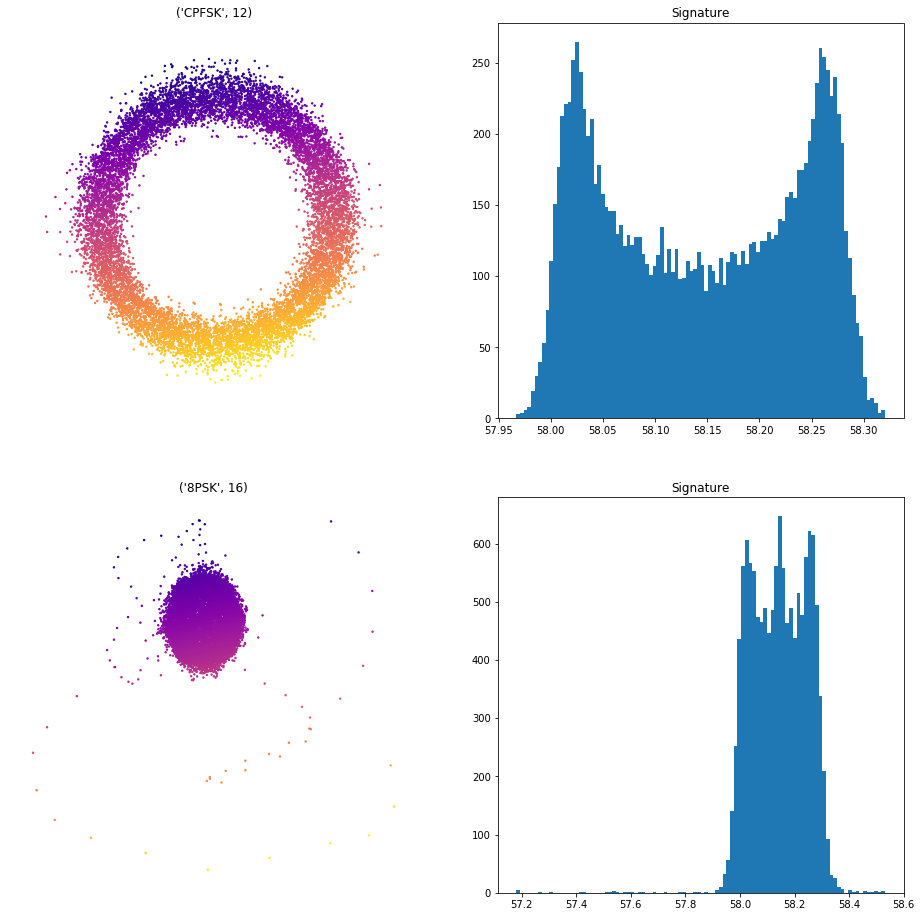

In [12]:
fig, ((ax11, ax21), (ax12, ax22)) = plt.subplots(2, 2, figsize=(16, 16))
mod = 94
scatter(mdl, cmap='plasma_r', l=mod, ax=ax11)
ax11.set_title(list[mod]); clean_up(ax11)
hist(mdl, cmap='plasma_r', l=mod, ax=ax21)
ax21.set_title('Signature')
mod = 104
scatter(mdl, cmap='plasma_r', l=mod, ax=ax12)
ax12.set_title(list[mod]); clean_up(ax12)
hist(mdl, cmap='plasma_r', l=mod, ax=ax22)
ax22.set_title('Signature')
plt.savefig('trajectoryANDsignature')

In [13]:
# lets see how much one can gain for embeded data with SVM! 
x = []
y = []
mini = -1
maxi = +1 
for i in range(len(list)):
    for j in range(delta):
        dummy = np.concatenate(mdl.transform(trajs[i*delta+j:i*delta+j+1]))[::1].ravel()
        #bins = np.linspace(mini, maxi, 51)
        #x.append(np.histogram(dummy, bins)[0])
        x.append(dummy)
        y.append(i)
y = label_binarize(y, classes=range(0, len(list)))       
x = np.asarray(x)
y = np.asarray(y)

In [14]:
#plt.figure(figsize=(4, 4))
#plt.imshow(y)
#plt.show()
print (x.shape, y.shape)

(22000, 128) (22000, 220)


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5)

In [16]:
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', tol=1e-2))
y_score = classifier.fit(x_train, y_train).decision_function(x_test)

In [17]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(list)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

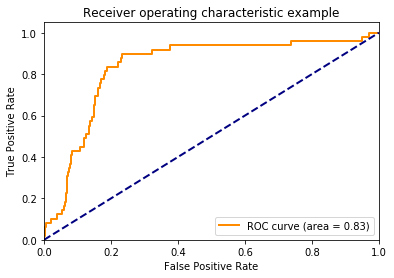

In [18]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

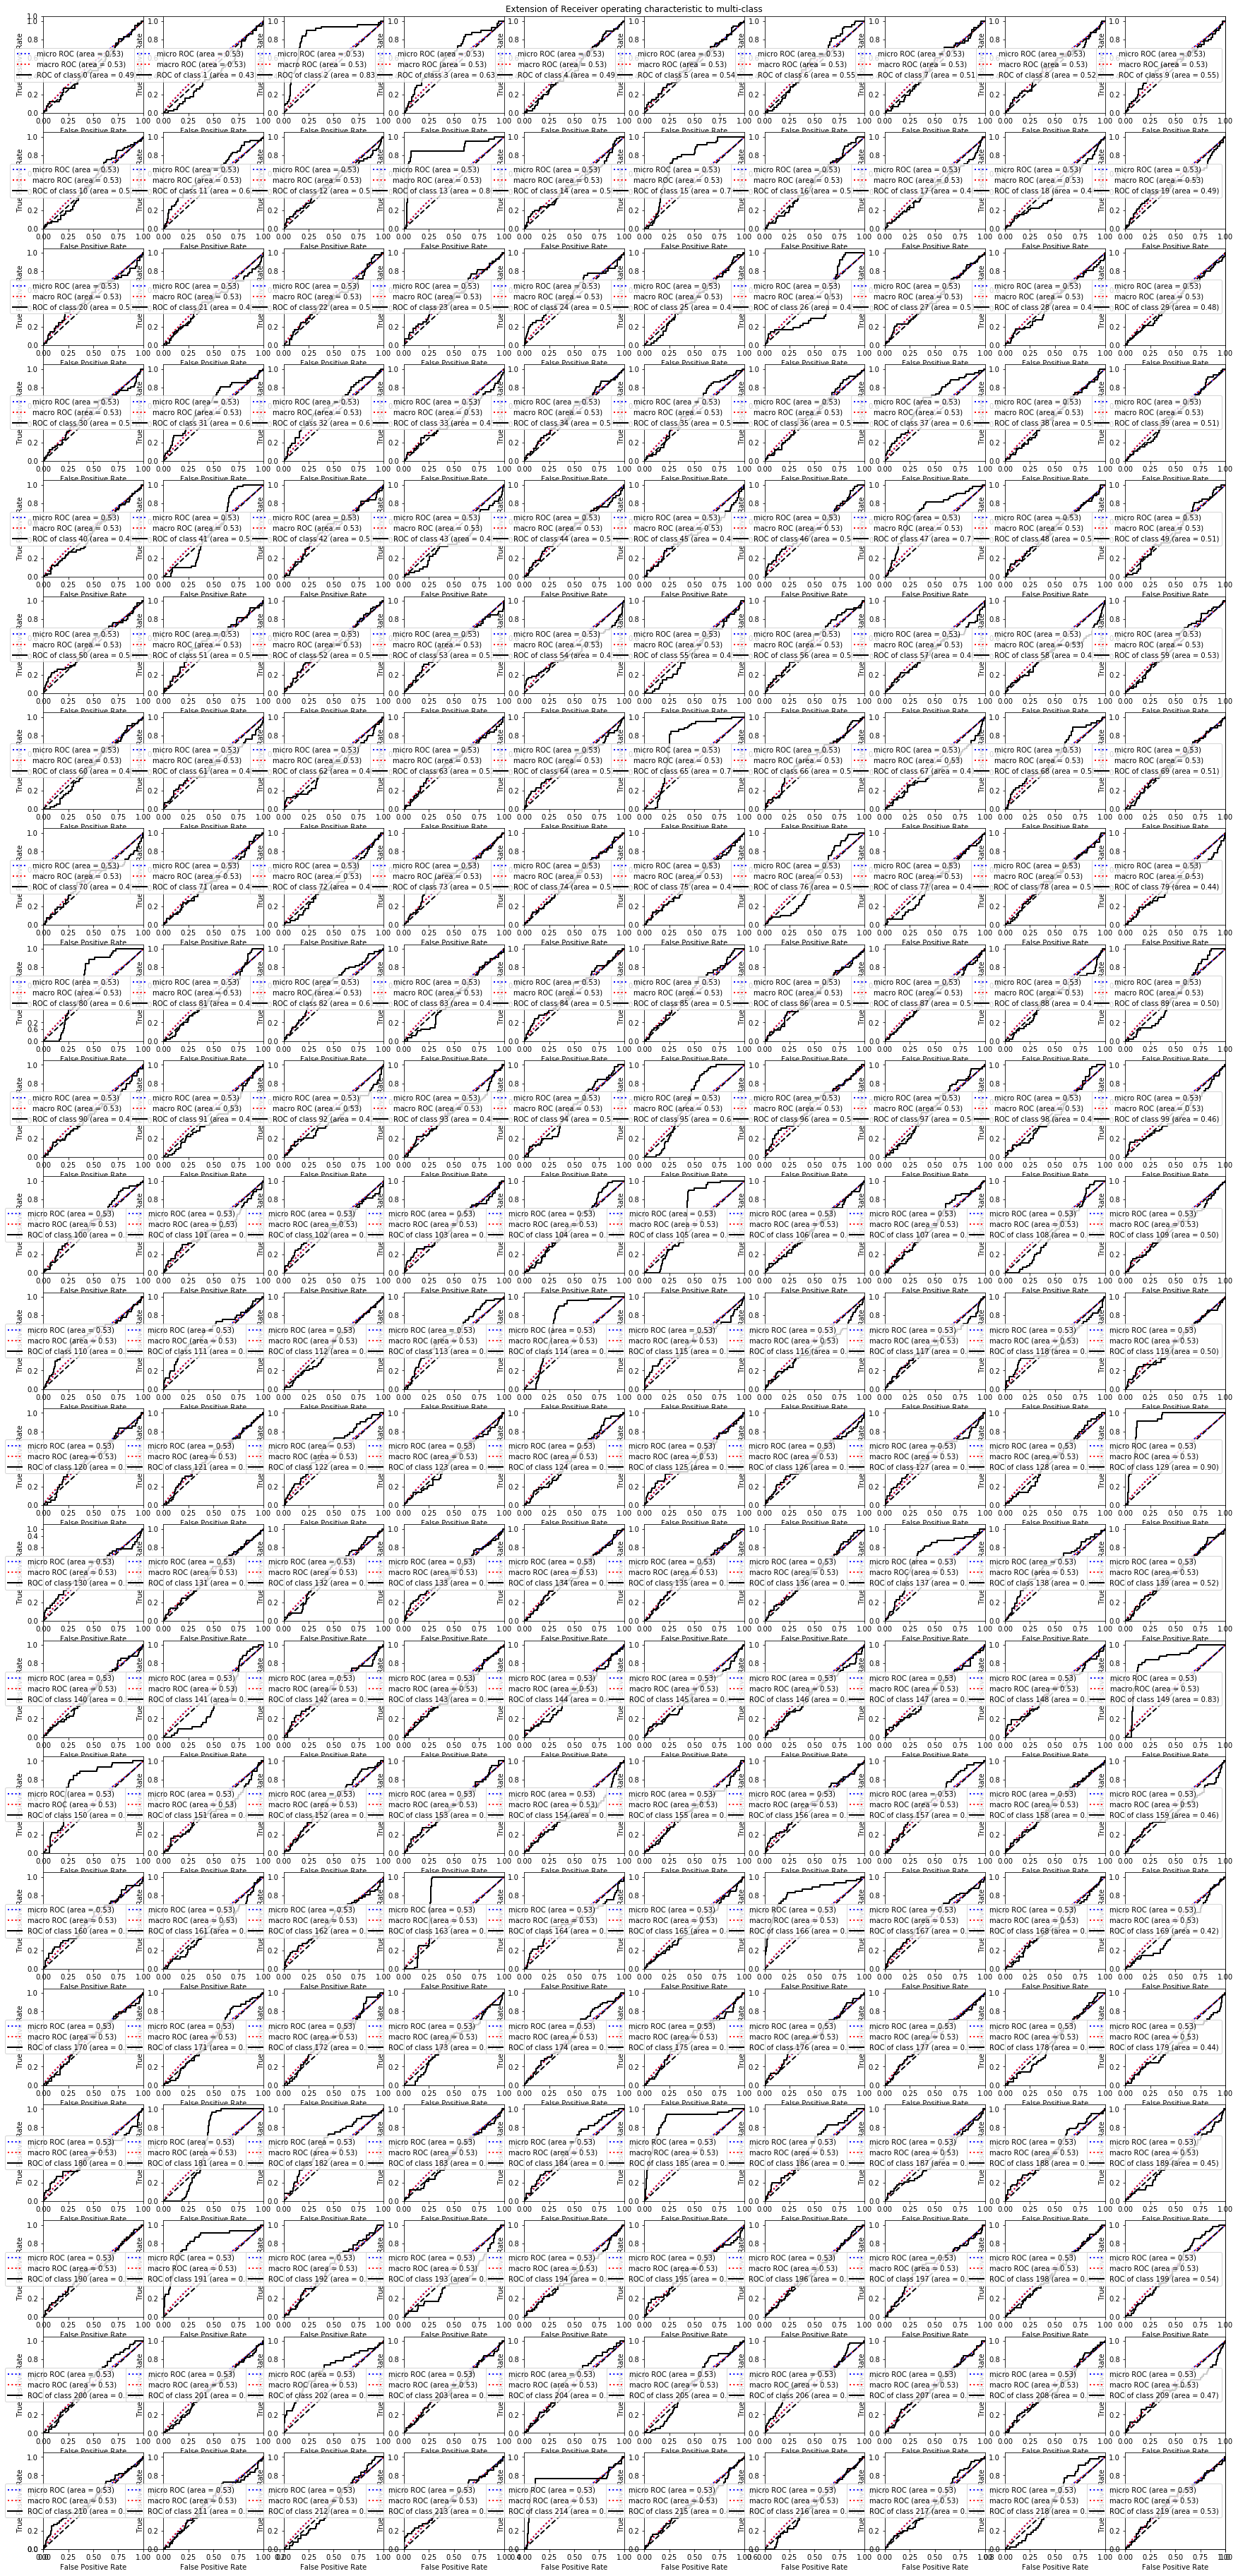

In [42]:
# Compute macro-average ROC curve and ROC area
n_classes = len(list)

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

fig = plt.figure(figsize=(3*10, 3*22))
plt.title('Extension of Receiver operating characteristic to multi-class')
c = 0
for i in range(22):
    for j in range(10):
        ax = fig.add_subplot(1*22, 1*10, i*1*10+1*j+1);
        ax.plot(fpr["micro"], tpr["micro"], label='micro ROC (area = {0:0.2f})'''.format(roc_auc["micro"]), color='blue', linestyle=':', linewidth=2)
        ax.plot(fpr["macro"], tpr["macro"], label='macro ROC (area = {0:0.2f})'''.format(roc_auc["macro"]), color='red', linestyle=':', linewidth=2)
        ax.plot(fpr[c], tpr[c], color='black', lw=lw, label='ROC of class {0} (area = {1:0.2f})'''.format(c, roc_auc[c]))
        c+=1
        plt.plot([0, 1], [0, 1], 'k--', color='black', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="right")
plt.savefig('auc.png')

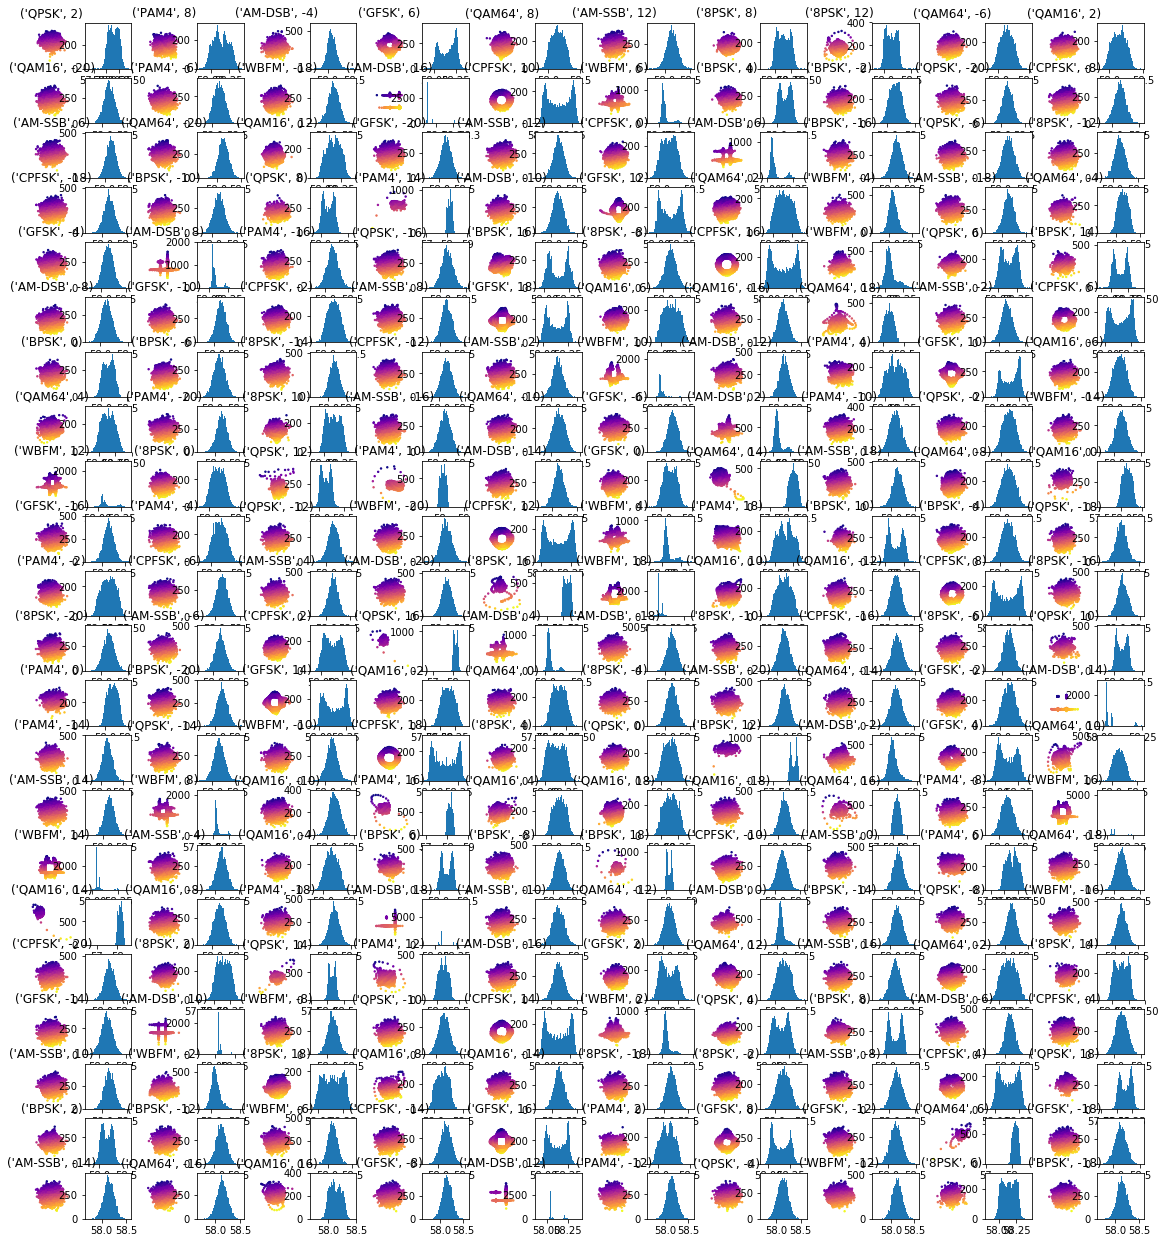

In [43]:
fig = plt.figure(figsize=(2*10, 1*22))
c = 0
for i in range(22):
    for j in range(10):
        ax1 = fig.add_subplot(1*22, 2*10, i*2*10+2*j+1)
        ax2 = fig.add_subplot(1*22, 2*10, i*2*10+2*j+2)
        scatter(mdl, cmap='plasma_r', l=c, ax=ax1)
        ax1.set_title(list[c]); clean_up(ax1)
        hist(mdl, cmap='plasma_r', l=c, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result.png')
#plt.close(fig)